In [29]:
import numpy as np
import cv2
import pandas as pd
import glob
from sklearn import svm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import os
from sklearn import metrics

## Functions
I prefer to have the utility functions all at the top of my notebook

In [2]:
def boundingBoxFromXML(path):
    '''takes and XML file path, returns the four corners of a bounding box
        depends on python xml 
        import xml.etree.ElementTree as ET
    '''
    
    #import the xml file and set a root
    tree = ET.parse(path)
    root = tree.getroot()
    
    #navigate to the bounding box
    root = root.find('object')    
    root = root.find('bndbox')
    
    #get the corners, order is xmin, ymin, xmax, ymax
    output = []
    for child in root:
        output.append( int(child.text) )
        
    return output

## Read in ship images
Note here the image is a larger image with a single ship in it. I use the associated xml file to get the bounding box and then crop out a smaller image with a ship in it. 

In [3]:
#first read the image file paths
shipImagePaths = glob.glob("MASATI-v2/ship/*.png")
shipImagePaths.sort()

#next read the xml label file paths
shipLabelPaths = glob.glob("MASATI-v2/ship_labels/*.xml")
shipLabelPaths.sort()

#container for ship images
imagesOfShips = []

#next loop over all the images and parse the XML file along the way
for i in range(1000):  #for now just 100 images
    
    #print shipImagePaths[i], shipLabelPaths[i]
    #read the image with opencv
    image = cv2.imread(shipImagePaths[i]) #BGR format not in RGB
    
    #parse the XML file to get the bounding box
    box = boundingBoxFromXML(shipLabelPaths[i])
    
    #crop out the ship using numpy
    imageCropped = image[box[1]:box[3], box[0]:box[2]] #[y:y+h, x:x+w] 
    
    #record the image
    imagesOfShips.append(imageCropped)

## Read in the images of ocean
Here I'll just read in the images and we can resize them later

In [4]:
#read the ocean image paths
oceanImagePaths = glob.glob("MASATI-v2/water/*.png")

#container for ocean images
imagesOfOcean = []

#loop 
for i in range(1000):
    
    #read in the image with opencv
    imagesOfOcean.append(cv2.imread(oceanImagePaths[i]))

## Some vis
Here I plot 36 random ships to get an idea what they look like in these image thumbnails

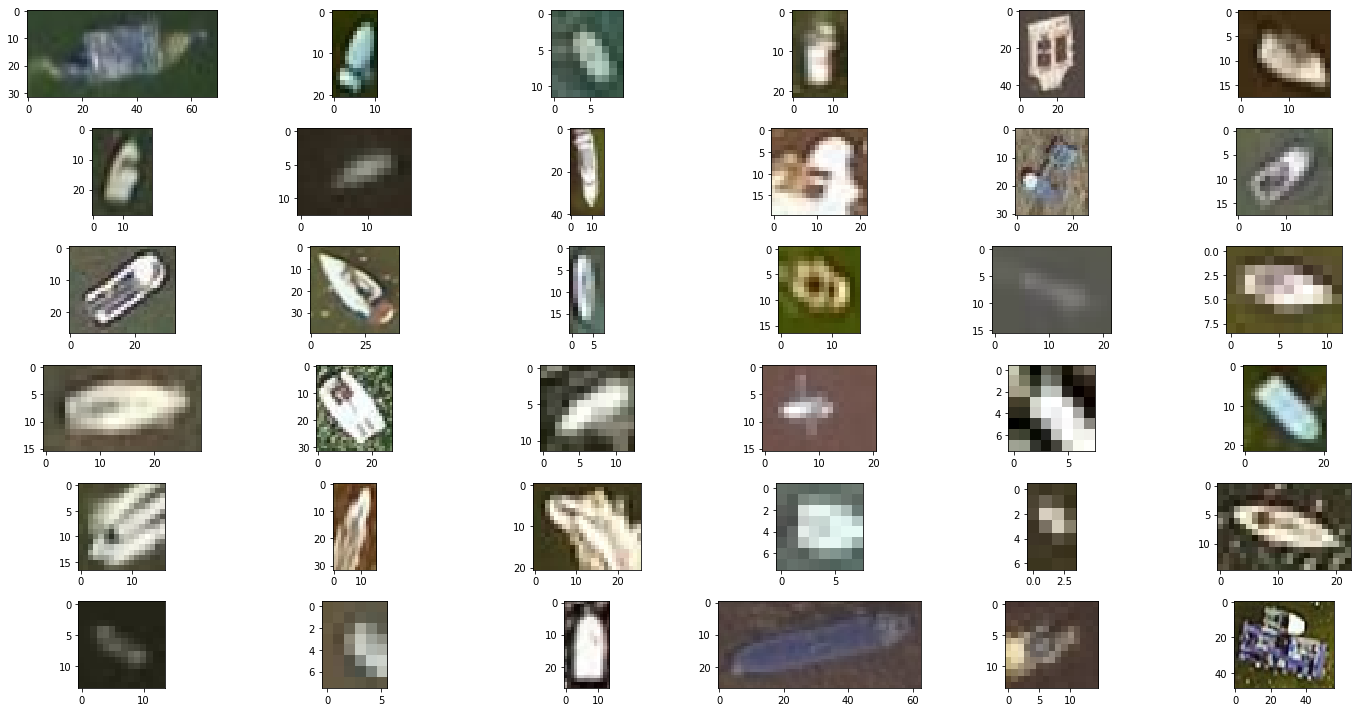

In [5]:
#plt subplot setup
fig, axs = plt.subplots(6, 6, figsize=(20, 10)) 

#loop to plot some random images for visulaztion purposes
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(imagesOfShips[np.random.randint(len(imagesOfShips))])
    
plt.tight_layout()
plt.show()

## Assemble the dataset
Here I'll put together the arrays needed to train the model, the features and labels. Unlike the other models our group has chosen, this will use normailze RAW images.

In [11]:
#containers for data
features = []
labels = []

#loop over the ships to make feature vectors
for i in range(len(imagesOfShips)):
    
    #resize the image to 30x30, normailze along the way
    image = cv2.resize(imagesOfShips[i], (30,30)) / 255.

    #add to the dataset
    features.append(image)
    labels.append(1)
    
#loop over the ocean to make feature vectors
for i in range(len(imagesOfOcean)):
    
    #resize the image to 30x30, normalize along the way
    image = cv2.resize(imagesOfOcean[i], (30,30)) / 255.
    
    #add to the dataset
    features.append(image)
    labels.append(0)
    
#shuffle the data
features, labels = shuffle(features, labels)

#split into training and validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

#one hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#expand the dimensions of the images
X_train = np.array(X_train)
X_test = np.array(X_test)

## Function to build a model
Now we need a function that returns a CNN model for training. This function takes some parameters that we will tune, and returns the compiled model, ready for training

In [7]:
def buildModel(conv_layers, filters, pooling_on):
    
    # define the keras model
    model = Sequential()
    
    #add a conv layer with pooling
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', input_shape=(30,30,3)))
    if(pooling_on == True):
        model.add(MaxPooling2D(pool_size=(3, 3), strides=1, padding="valid"))

    for i in range(conv_layers - 1):
        
        #add a conv layer with pooling
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu'))
        if(pooling_on == True):
            model.add(MaxPooling2D(pool_size=(3, 3), strides=1, padding="valid"))

    #flatten the model and format for binary classification, this will not change
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax'))

    #compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

## First optimize the number of conv layers in the network
The network design is an open question, here we will consider how many layers we need to get the best accuracy. Every "layer" consists of a Conv2D layer and subsuquent max pooling layer. We will test between one and 7 layers and see what returns the best validation accuracy. Note that while we perform this search, we fix all other parameters. Note we also test the use of pooling in tandem with the Conv2D layer, as we expand the network, we networks with and without max pooling.

Here we expand and train a network with no pooling layers

In [12]:
#logging containers
performance_convs_no_pooling = []

#loop from 1 to 7 to find the best number of conv layers in our model
for i in range(1, 8):
    
    #build a model with i conv layers, using 64 filters for each layer, with no pooling
    model = buildModel(i, 64, False)  
    
    #train the model
    model.fit(X_train, y_train, epochs=10, batch_size=10)
    
    #make some predictions
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)

    #undo the one hot encoding on the test labels
    y = np.argmax(y_test, axis=1)

    #get the accurac and log
    performance_convs_no_pooling.append(accuracy_score(pred, y))

Epoch 1/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.1578 - acc: 0.9394
Epoch 2/10
1600/1600 [==============================] - 1s 913us/step - loss: 0.0719 - acc: 0.9819
Epoch 3/10
1600/1600 [==============================] - 1s 906us/step - loss: 0.0546 - acc: 0.9881
Epoch 4/10
1600/1600 [==============================] - 1s 907us/step - loss: 0.0632 - acc: 0.9825
Epoch 5/10
1600/1600 [==============================] - 1s 902us/step - loss: 0.0465 - acc: 0.9856
Epoch 6/10
1600/1600 [==============================] - 2s 949us/step - loss: 0.0298 - acc: 0.9906
Epoch 7/10
1600/1600 [==============================] - 1s 914us/step - loss: 0.0366 - acc: 0.9887
Epoch 8/10
1600/1600 [==============================] - 1s 903us/step - loss: 0.0277 - acc: 0.9919
Epoch 9/10
1600/1600 [==============================] - 1s 933us/step - loss: 0.0178 - acc: 0.9950
Epoch 10/10
1600/1600 [==============================] - 2s 942us/step - loss: 0.0210 - acc: 0.9937
Epoch 1/10


Here we expand and train a network WITH pooling layers

In [13]:
#logging containers
performance_convs = []
convs = []

#loop from 1 to 7 to find the best number of conv layers in our model
for i in range(1, 8):
    
    #build a model with i conv layers, using 64 filters for each layer
    model = buildModel(i, 64, True)  
    
    #train the model
    model.fit(X_train, y_train, epochs=10, batch_size=10)
    
    #make some predictions
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)

    #undo the one hot encoding on the test labels
    y = np.argmax(y_test, axis=1)

    #get the accurac and log
    performance_convs.append(accuracy_score(pred, y))
    convs.append(i)

Epoch 1/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.1824 - acc: 0.9281
Epoch 2/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0728 - acc: 0.9769
Epoch 3/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0426 - acc: 0.9869
Epoch 4/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0606 - acc: 0.9825
Epoch 5/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0593 - acc: 0.9837
Epoch 6/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0331 - acc: 0.9919
Epoch 7/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0260 - acc: 0.9931
Epoch 8/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0218 - acc: 0.9944
Epoch 9/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0199 - acc: 0.9950
Epoch 10/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0102 - acc: 0.9962
Epoch 1/10
1600/1600 [=======

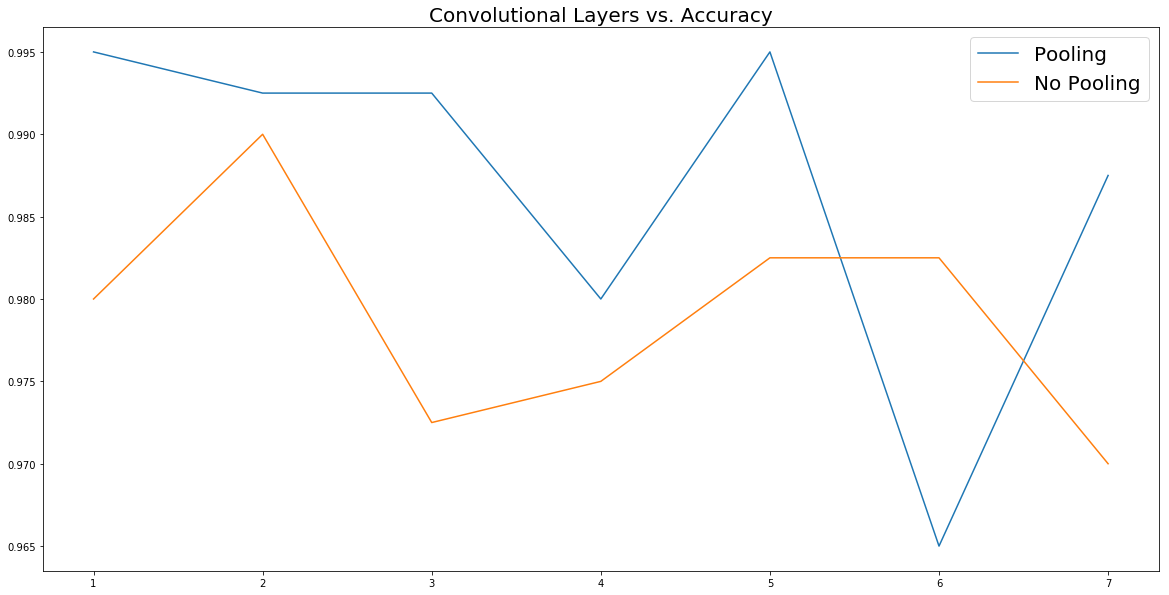

0
0.995
0.99


In [36]:
plt.figure(figsize=(20,10))
plt.plot(convs, performance_convs)
plt.plot(convs, performance_convs_no_pooling)
plt.legend(["Pooling", "No Pooling"],fontsize=20)
plt.title("Convolutional Layers vs. Accuracy",fontsize=20)
plt.show()

print np.argmax(performance_convs)
print np.max(performance_convs)
print np.max(performance_convs_no_pooling)

## Next Find the best number of filters
Now that we have our network design, we need to find the best number of filters. We will try from 16 to 80 in incrments of 16. 

In [17]:
#logging containers
performance_filters = []
filters_ = []

#loop to find the best number of filters
for i in range(16, 96, 16):
    
    #build a model with 1 conv layers, using i filters for each layer
    model = buildModel(1, i, True)  
    
    #train the model
    model.fit(X_train, y_train, epochs=10, batch_size=10)
    
    #make some predictions
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)

    #undo the one hot encoding on the test labels
    y = np.argmax(y_test, axis=1)

    #get the accurac and log
    performance_filters.append(accuracy_score(pred, y))
    filters_.append(i)
    
    print(accuracy_score(pred, y), i)

Epoch 1/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.1338 - acc: 0.9544
Epoch 2/10
1600/1600 [==============================] - 1s 455us/step - loss: 0.0700 - acc: 0.9812
Epoch 3/10
1600/1600 [==============================] - 1s 545us/step - loss: 0.0587 - acc: 0.9794
Epoch 4/10
1600/1600 [==============================] - 1s 554us/step - loss: 0.0469 - acc: 0.9906
Epoch 5/10
1600/1600 [==============================] - 1s 510us/step - loss: 0.0405 - acc: 0.9869
Epoch 6/10
1600/1600 [==============================] - 1s 562us/step - loss: 0.0414 - acc: 0.9881
Epoch 7/10
1600/1600 [==============================] - 1s 484us/step - loss: 0.0316 - acc: 0.9906
Epoch 8/10
1600/1600 [==============================] - 1s 672us/step - loss: 0.0234 - acc: 0.9919
Epoch 9/10
1600/1600 [==============================] - 1s 552us/step - loss: 0.0308 - acc: 0.9950
Epoch 10/10
1600/1600 [==============================] - 1s 571us/step - loss: 0.0197 - acc: 0.9937
(0.99, 16)


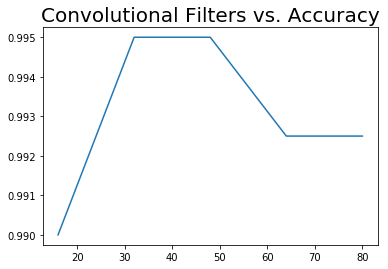

1


In [37]:
plt.plot(filters_, performance_filters)
plt.title("Convolutional Filters vs. Accuracy", fontsize=20)
plt.show()

print np.argmax(performance_filters)

## Next find the best batch size
The next question is what is the ideal batch size for this dataset. As we know, batch size can have a huge influence on training outcomes. Here we consider batch sizes from 10 to 100 in increments of 10. 

In [21]:
#logging containers
performance_batches = []
batches_ = []

#loop from 1 to 7 to find the best number of conv layers in our model
for i in range(10, 110, 10):
    
    #build a model with 3 conv layers, using 80 filters for each layer
    model = buildModel(1, 32, True)  
    
    #train the model
    model.fit(X_train, y_train, epochs=10, batch_size=i)
    
    #make some predictions
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)

    #undo the one hot encoding on the test labels
    y = np.argmax(y_test, axis=1)

    #get the accurac and log
    performance_batches.append(accuracy_score(pred, y))
    batches_.append(i)
    
    print(accuracy_score(pred, y), i)

Epoch 1/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.1684 - acc: 0.9337
Epoch 2/10
1600/1600 [==============================] - 1s 835us/step - loss: 0.0777 - acc: 0.9762
Epoch 3/10
1600/1600 [==============================] - 1s 754us/step - loss: 0.0568 - acc: 0.9850
Epoch 4/10
1600/1600 [==============================] - 1s 733us/step - loss: 0.0532 - acc: 0.9775
Epoch 5/10
1600/1600 [==============================] - 1s 785us/step - loss: 0.0303 - acc: 0.9912
Epoch 6/10
1600/1600 [==============================] - 1s 736us/step - loss: 0.0295 - acc: 0.9925
Epoch 7/10
1600/1600 [==============================] - 1s 731us/step - loss: 0.0287 - acc: 0.9887
Epoch 8/10
1600/1600 [==============================] - 1s 867us/step - loss: 0.0164 - acc: 0.9937
Epoch 9/10
1600/1600 [==============================] - 1s 815us/step - loss: 0.0162 - acc: 0.9962
Epoch 10/10
1600/1600 [==============================] - 1s 806us/step - loss: 0.0136 - acc: 0.9962
(0.985, 10)

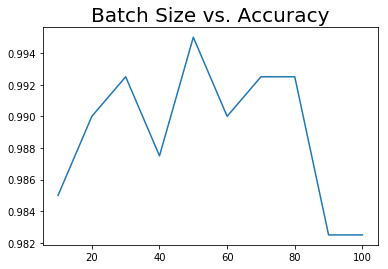

50


In [38]:
plt.plot(batches_, performance_batches)
plt.title("Batch Size vs. Accuracy", fontsize=20)
plt.show()

print batches_[np.argmax(performance_batches)]

## Next lets consider the number of epochs
One of the most critical items to consider with a CNN is the number of training epochs, here we will plot a range of epochs and show training vs. test accuracy, a classical diagram to pick this final parameter.

In [26]:
#logging containers
validation_acc = []
training_acc = []
epochs_ = []

#build a model with 3 conv layers, using 80 filters for each layer, this time outside of the loop
model = buildModel(1, 32, True)  
    
#loop from 1 to 7 to find the best number of conv layers in our model
for epoch in range(1, 100):
    
    #train the model, one epoch at a time so we can log the results
    model.fit(X_train, y_train, epochs=1, batch_size=50)
    
    #make some predictions on the test data
    pred_test = model.predict(X_test)
    pred_test = np.argmax(pred_test, axis=1)
    y_pred_test = np.argmax(y_test, axis=1)
    
    #make some predictions on the test data
    pred_train = model.predict(X_train)
    pred_train = np.argmax(pred_train, axis=1)
    y_pred_train = np.argmax(y_train, axis=1)

    #get the accuracy and log
    validation_acc.append(accuracy_score(pred_test, y_pred_test))
    training_acc.append(accuracy_score(pred_train, y_pred_train))
    epochs_.append(epoch)

Epoch 1/1
1600/1600 [==============================] - 1s 737us/step - loss: 0.4019 - acc: 0.8094
Epoch 1/1
1600/1600 [==============================] - 0s 51us/step - loss: 0.1005 - acc: 0.9738
Epoch 1/1
1600/1600 [==============================] - 0s 49us/step - loss: 0.0749 - acc: 0.9788
Epoch 1/1
1600/1600 [==============================] - 0s 99us/step - loss: 0.0656 - acc: 0.9825
Epoch 1/1
1600/1600 [==============================] - 0s 98us/step - loss: 0.0732 - acc: 0.9763
Epoch 1/1
1600/1600 [==============================] - 0s 84us/step - loss: 0.0516 - acc: 0.9869
Epoch 1/1
1600/1600 [==============================] - 0s 103us/step - loss: 0.0339 - acc: 0.9906
Epoch 1/1
1600/1600 [==============================] - 0s 101us/step - loss: 0.0326 - acc: 0.9925
Epoch 1/1
1600/1600 [==============================] - 0s 57us/step - loss: 0.0351 - acc: 0.9888
Epoch 1/1
1600/1600 [==============================] - 0s 49us/step - loss: 0.0301 - acc: 0.9938
Epoch 1/1
1600/1600 [======

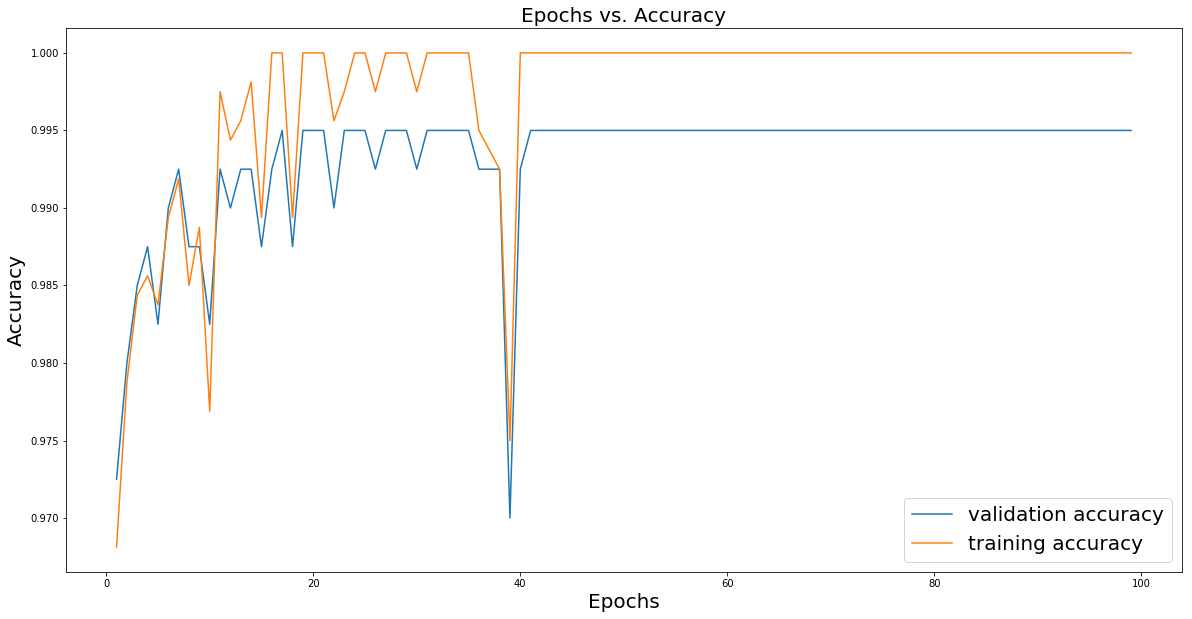

In [39]:
plt.figure(figsize=(20,10))
plt.plot(epochs_, validation_acc)
plt.plot(epochs_, training_acc)

plt.title("Epochs vs. Accuracy",fontsize=20)
plt.legend(['validation accuracy','training accuracy'],fontsize=20)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.show()

1.0


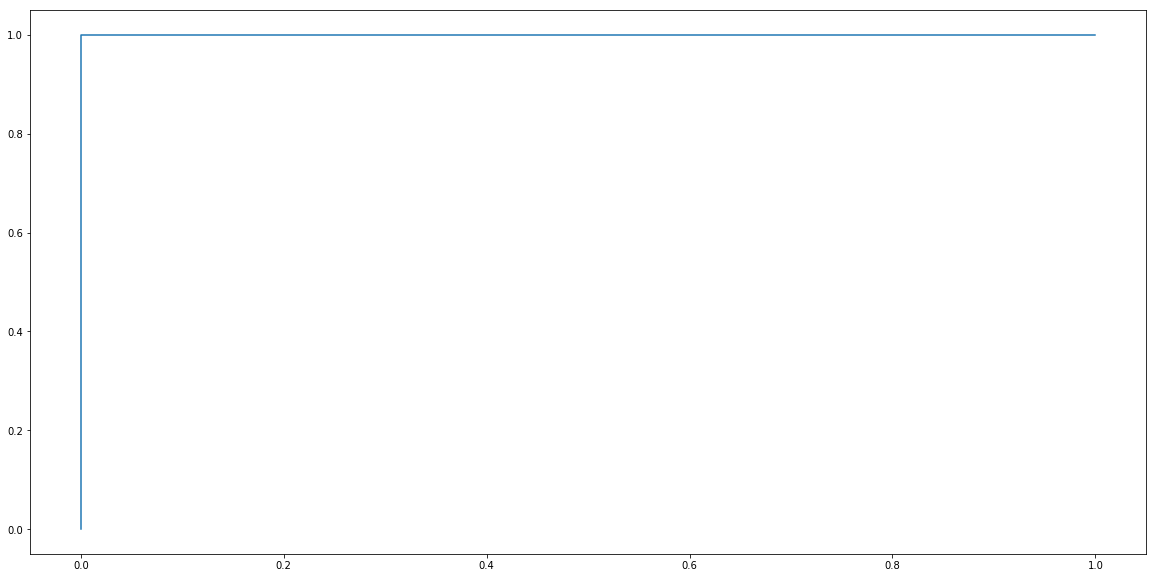

In [32]:
plt.figure(figsize=(20,10))

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_pred_train, pred_train)
a1 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr)
print(a1)
np.save("CNN.npy", np.column_stack((fpr, tpr)))

In [40]:
print np.max(validation_acc)

0.995


In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 43266     
Total params: 44,162
Trainable params: 44,162
Non-trainable params: 0
_________________________________________________________________
